<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<AxesSubplot: >

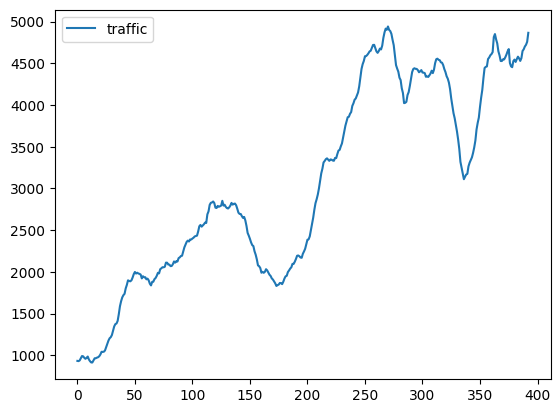

In [1]:
import pandas as pd
df = pd.read_csv(r'./data/website_data.csv')
df.info()

df.plot()

<AxesSubplot: >

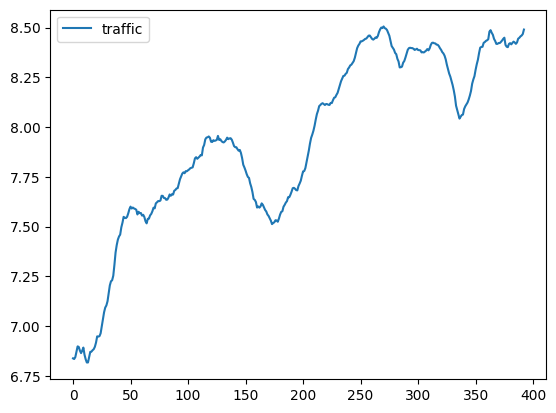

In [2]:
import numpy as np
df = np.log(df) # don't forget to transform the data back when making real predictions

df.plot()

In [3]:
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

/Users/huarongshen/opt/anaconda3/envs/myownenv39/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


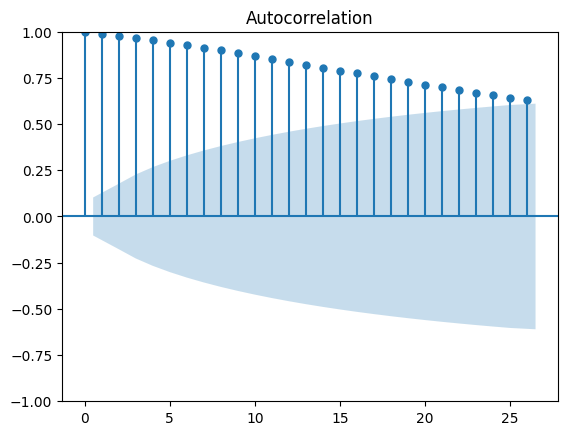

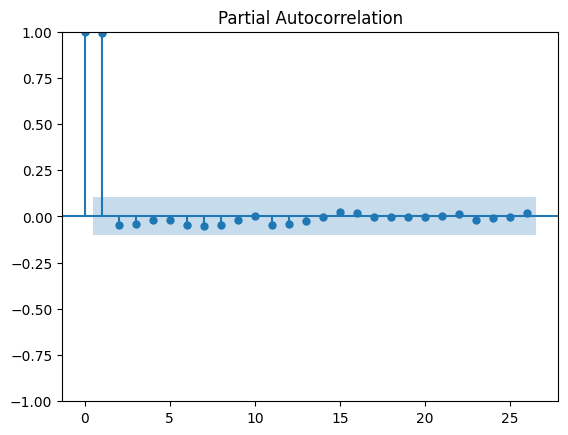

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_train)

output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"], columns=['value'])
output['value']['Test Statistic Value'] = result[0]
output['value']['p-value'] = result[1]
output['value']['Lags Used'] = result[2]
output['value']['Number of Observations Used'] = result[3]
output['value']['Critical Value(1%)'] = result[4]['1%']
output['value']['Critical Value(5%)'] = result[4]['5%']
output['value']['Critical Value(10%)'] = result[4]['10%']
output

,value
Test Statistic Value,-2.108122
p-value,0.241261
Lags Used,16
Number of Observations Used,346
Critical Value(1%),-3.449392
Critical Value(5%),-2.86993
Critical Value(10%),-2.57124


<AxesSubplot: >

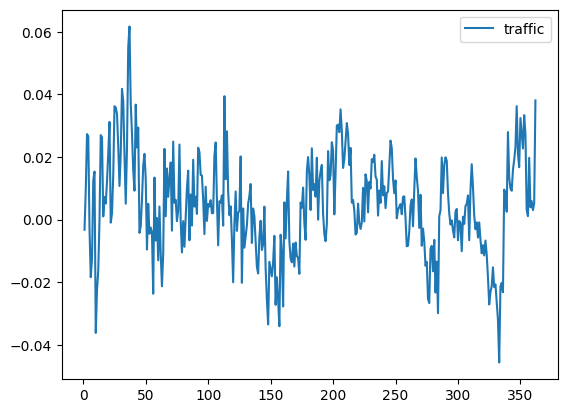

In [8]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

/Users/huarongshen/opt/anaconda3/envs/myownenv39/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


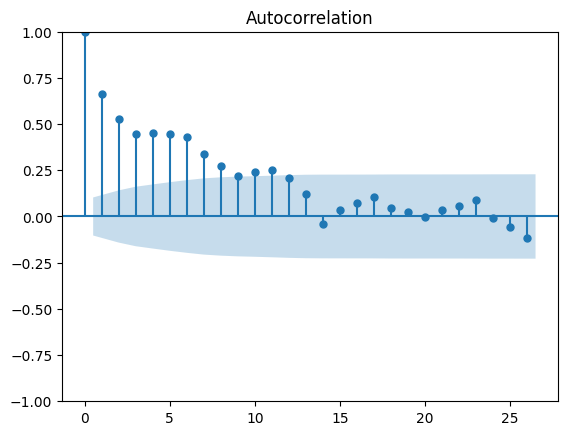

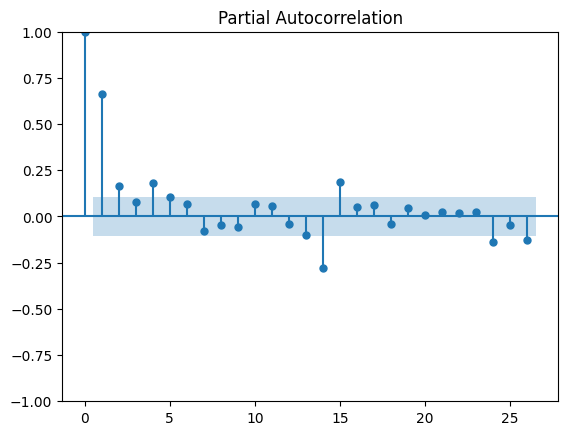

In [9]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [10]:
result = adfuller(df_train_diff)

output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"], columns=['value'])
output['value']['Test Statistic Value'] = result[0]
output['value']['p-value'] = result[1]
output['value']['Lags Used'] = result[2]
output['value']['Number of Observations Used'] = result[3]
output['value']['Critical Value(1%)'] = result[4]['1%']
output['value']['Critical Value(5%)'] = result[4]['5%']
output['value']['Critical Value(10%)'] = result[4]['10%']
output

,value
Test Statistic Value,-3.165676
p-value,0.022059
Lags Used,15
Number of Observations Used,346
Critical Value(1%),-3.449392
Critical Value(5%),-2.86993
Critical Value(10%),-2.57124


In [11]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Sun, 12 Mar 2023   AIC                          -2186.737
Time:                        11:08:27   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.0

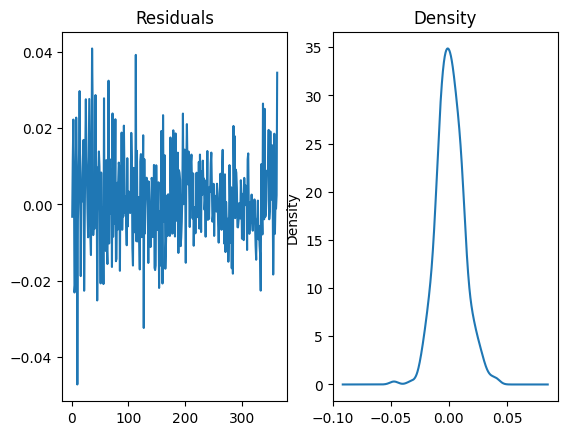

In [12]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

/Users/huarongshen/opt/anaconda3/envs/myownenv39/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


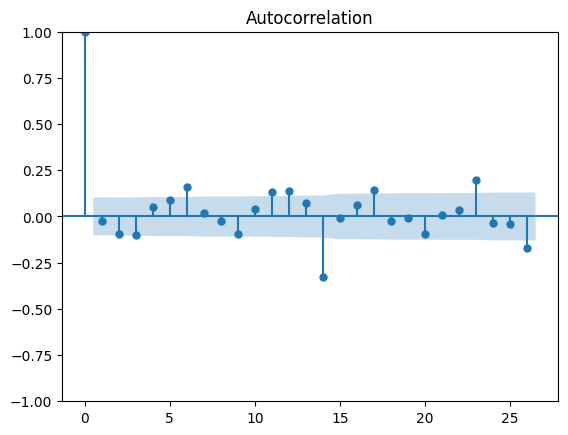

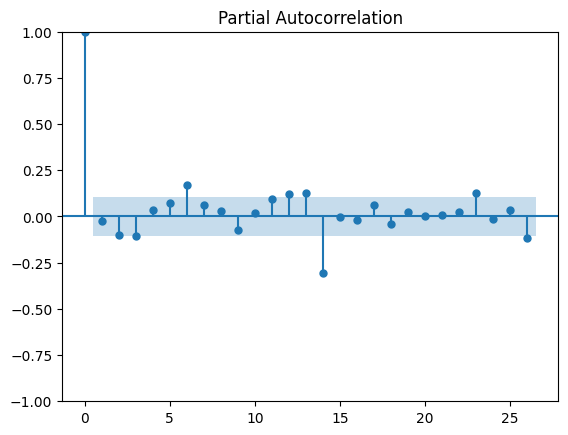

In [13]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<AxesSubplot: >

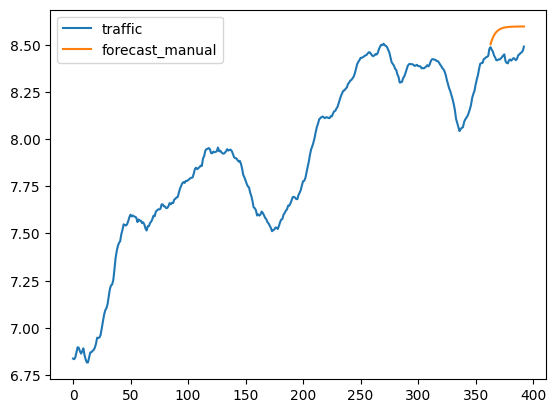

In [14]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [15]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

<AxesSubplot: >

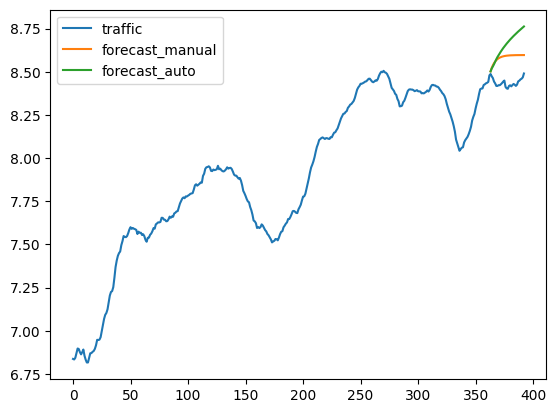

In [16]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.14514968388076604
mape - manual: 0.017216198515850756
rmse - manual: 0.15051403899106064


In [18]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.21837086247147314
mape - auto: 0.025893824537749202
rmse - auto: 0.2327919762901083
